# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [1]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from sklearn.linear_model import Lasso

%load_ext autoreload
%autoreload 2
import tools as lm 

## Read data 

In [2]:
dat = pd.read_csv('data/growth.csv')
lbldf = pd.read_csv('data/labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary

# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))

print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 86 columns (variables).


# Descriptive plots

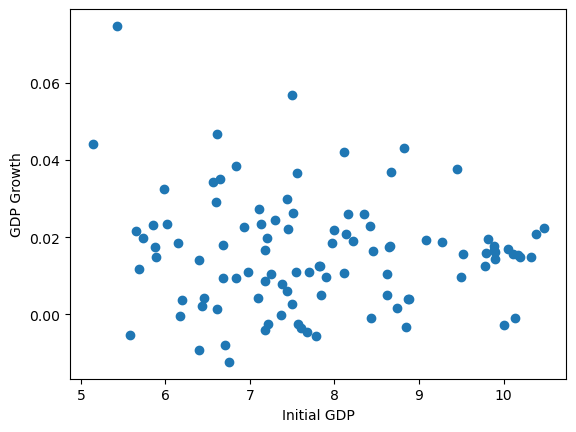

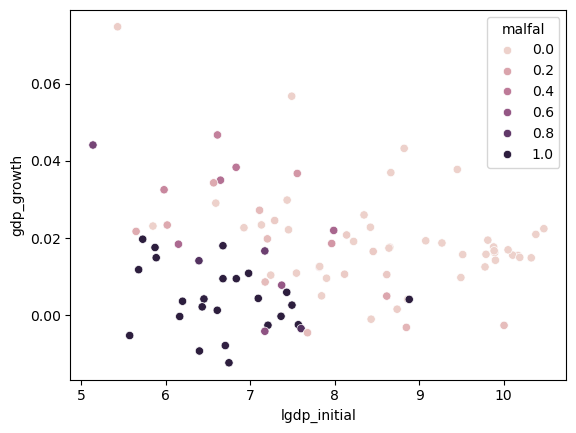

In [3]:
# Scatter plot of GDP growth against initial GDP
fig, ax = plt.subplots()
ax.scatter(dat['lgdp_initial'], dat['gdp_growth'])
ax.set_xlabel('Initial GDP')
ax.set_ylabel('GDP Growth')
plt.show()

# Accounting for the something
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='malfal');

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [4]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'educ':vv_educ,
         }

list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]


# Simple OLS

In [5]:
# 1. avoiding missings 
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)

# 2. extract dataset 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, ['constant','lgdp_initial']].values

# 3. run OLS
betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

[[ 2.24792211]
 [-0.08713416]]


# Adding more controls

In [6]:
vs = vv_all['geography'] + vv_all['religion']
xs = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, xs].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# add const. (unless this breaks the rank condition)
oo = np.ones((I.sum(),1))
X = np.hstack([X, oo])
xs.append('constant') # we put it in as the last element

# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X.T @ X) @ X.T @ y

# format nicely
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
pd.DataFrame({'β': betas[:,0]}, index=xs).round(3)

Mean y =  1.52% growth per year


,β
lgdp_initial,-1.118
pop_growth,6.830
investment_rate,0.068
tropicar,-0.411
distr,-0.000
distcr,0.001
distc,-0.003
suitavg,-1.063
temp,-0.204
suitgini,-0.771


In [7]:
# xLabels = 
# [col for col in vv_all['all'] if 'invest' in col]

mustCols = ['ls_bl','lh_bl','lp_bl','investment_rate','gdp_growth', 'lgdp_initial']

# remove rows with missing values of lgdp_initial and gdp_growth
data = dat.dropna(subset=mustCols)

# if no democracy data, set to 0
data.loc[data[['dem','demCGV','demBMR']].isna().any(axis=1), ['dem','demCGV','demBMR']] = 0

preN = data.shape[0]
data.iloc[:10,:10]

,code,marketref,dem,demCGV,demBMR,demreg,lp_bl,ls_bl,lh_bl,tropicar
4,ARG,34.144062,0.0,0.0,0.0,0.071429,72.400000,15.300000,4.000000,0.027089
7,AUS,29.444778,1.0,1.0,1.0,0.954545,29.300000,48.300000,21.500000,0.381887
8,AUT,38.210518,1.0,1.0,1.0,0.954545,57.263283,35.800000,2.600000,0.000000
10,BDI,NaN,0.0,0.0,0.0,0.032258,11.365340,0.912563,0.141201,1.000000
11,BEL,53.843560,1.0,1.0,1.0,0.954545,65.299510,28.700000,5.200000,0.000000
12,BEN,4.545453,0.0,0.0,0.0,0.032258,8.305782,2.140225,0.291849,1.000000
14,BGD,33.333332,0.0,0.0,0.0,0.000000,12.293732,6.104592,0.566647,0.421053
20,BLZ,50.000000,0.0,0.0,0.0,0.888889,78.600000,7.900000,1.400000,1.000000
21,BOL,61.486930,0.0,0.0,0.0,0.071429,26.650803,15.971729,4.245973,1.000000
22,BRA,23.809525,0.0,0.0,0.0,0.071429,46.000000,9.600000,2.000000,0.931233


### 

In [8]:
containing_all = mustCols[:]
for col in dat.columns:
    if col in ['code','europe','pother','pd1500.1','constant'] + mustCols + [col for col in dat.columns if col.startswith('gdp')]:
        continue
    if data[[col]].notnull().sum()[0]==preN:
        containing_all.append(col)


df = data[containing_all]
df = df.dropna(how='any')

# Define the number of samples and features
n = df.shape[0] # number of samples
p = df.shape[1] # number of features

# print the shape of the data 
print(f'Data contains {n} rows and {p} columns')


Data contains 86 rows and 37 columns


### Prepare data for analysis
Standardize the data.

In [9]:
# Define the labels 
Z_labels = [col for col in containing_all if col not in ['gdp_growth', 'lgdp_initial']]
Y_label = 'gdp_growth'
d_label = 'lgdp_initial'

def standardize(X):
    """function for standardizing the data"""
    return (X - np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)

def prepare_data():
    # Define the data 
    Z = df[Z_labels].values
    y = df[Y_label].values
    d = df[d_label].values

    # Construct X as a matrix with d as the first column and Z as the rest
    X = np.column_stack((d,Z))

    # Standardize data
    X_stan = standardize(X)
    Z_stan = standardize(Z)
    d_stan = standardize(d)
    
    return X, y, d, Z, X_stan, Z_stan, d_stan


# Post Double lasso (PDL)
The model of which we are interested in estimating $\beta$ is given by
$$
g_i = \beta y_{i0} + \boldsymbol{z}_i \boldsymbol{\gamma} + u_i
$$

**Using PDL relies on the following steps:**

Step 1: Lasso $g$ on $y_0$ and $z$ to obtain $\widehat{\psi}$

Step 2: Lasso $y_0$ on $z$ to obtain $\widehat{\gamma}$

Step 3: Calculate $\widehat{\beta}_{\text{PDL}}$ as  
$$    
\hat{\beta}_{PDL} 
= \frac{\sum_{i=1}^{n}(y_{i0} - \boldsymbol{z}_i\hat{\boldsymbol{\psi}})(g_i - \boldsymbol{z}_i\hat{\boldsymbol{\gamma}})}
{\sum_{i=1}^{n}(y_{i0} - \boldsymbol{z}_i\hat{\boldsymbol{\psi}})y_{i0}}.$$
---

Step 0: Create a function that calculates the BRT 

In [10]:
def BRT(X_tilde,y):
    """ 
    Calculate the BRT penalty 
        Args:
            X_tilde: standardized features
            y: standardized target variable
    """
    (N,p) = X_tilde.shape
    sigma = np.std(y, ddof=1)
    c=1.1
    alpha=0.05

    penalty_BRT= (sigma*c)/np.sqrt(N)*norm.ppf(1-alpha/(2*p))

    return penalty_BRT

X, y, d, Z, X_stan, Z_stan, d_stan = prepare_data()

Step 1: Lasso $g$ using $y_0$ and $z$

In [11]:
# Calculate BRT
penalty_BRTyx = BRT(X_tilde=X_stan,y=y, )
print(f"lambda_BRT = {penalty_BRTyx:2.4f}")

# Run Lasso 
fit_BRTyx = Lasso(penalty_BRTyx, max_iter=10_000, fit_intercept=True).fit(X_stan, y)
coefs=fit_BRTyx.coef_

# Calculate residuals
resyx = y-fit_BRTyx.predict(X_stan)

# Calculate Y - Z@gamma (epsilon + alpha*d)
resyxz = resyx + d_stan*coefs[0]

# Display first coefficient
print(f"First coefficient = {coefs[0]:.8f}",)

# Display the coefficients
print('',coefs)

lambda_BRT = 0.0055
First coefficient = -0.00000000
 [-0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.         -0.
 -0.         -0.          0.          0.          0.         -0.
 -0.          0.          0.          0.          0.          0.
  0.         -0.          0.00067545 -0.         -0.         -0.
 -0.         -0.          0.00090799  0.         -0.          0.        ]


Step 2: Lasso $y_{0}$ using $Z$

In [12]:
# Calculate BRT
penalty_BRTdz = BRT(Z_stan, d)
print(f"lambda_BRT = {penalty_BRTdz:2.4f}")

# Run Lasso
fit_BRTdz = Lasso(penalty_BRTdz, max_iter=10000,fit_intercept=True).fit(Z_stan, d)
coefs=fit_BRTdz.coef_

# Calculate residuals
resdz=d-fit_BRTdz.predict(Z_stan)

# Display first coefficient
print(f"First coefficient = {coefs[0]:.8f}",)

# Display the coefficients
print('',coefs)

lambda_BRT = 0.5258
First coefficient = 0.08224087
 [ 0.08224087  0.10021007  0.04417316  0.          0.          0.
  0.          0.         -0.         -0.         -0.35987575 -0.
 -0.          0.         -0.         -0.          0.         -0.
 -0.         -0.          0.          0.         -0.         -0.
 -0.         -0.          0.          0.          0.          0.
 -0.         -0.         -0.         -0.         -0.        ]


Step 3: Estimate beta and calculate the implied variance estimate, $\check{\sigma}^2$, and calculate the standard deviation of $\check{\beta}$.

In [13]:
# Calculate alpha
num = resdz@resyxz
denom = resdz@d
beta_PDL_brt = num/denom

# Display alpha
print(f"beta_PDL = {beta_PDL_brt:.8f}",)

N = len(y)
# Calculate variance    
num = resdz**2@resyx**2/N
denom = (resdz.T@resdz/N)**2
sigma2_PDL_brt = num/denom

# Display variance
print(f"sigma2_PDL = {sigma2_PDL_brt:.4f}")

# Calculate standard error
se_PDL_brt = np.sqrt(sigma2_PDL_brt/N)

# Display standard error
print(f"se_PDL = {se_PDL_brt:.4f}",)

# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_PDL_brt  = beta_PDL_brt - q * se_PDL_brt
CI_high_PDL_brt = beta_PDL_brt + q * se_PDL_brt

# Display confidence interval
print(f"CI_PDL = ({CI_low_PDL_brt:.4f}, {CI_high_PDL_brt:.4f})")

beta_PDL = -0.00296457
sigma2_PDL = 0.0003
se_PDL = 0.0020
CI_PDL = (-0.0068, 0.0009)


Compare with a simple OLS regression.

In [14]:
beta0 = np.linalg.inv(d.reshape(-1,1).T@d.reshape(-1,1)) @ d.reshape(-1,1).T @ y

d_ = np.column_stack((np.ones(N), d))
beta1 = np.linalg.inv(d_.T@d_) @ d_.T @ y

# Display the different betas 
print(f"Beta calculated without an intercept: {beta0[0]:.4f}",
        f"\nBeta calculated with an intercept: {beta1[1]:.4f}")


Beta calculated without an intercept: 0.0020 
Beta calculated with an intercept: -0.0015


--- 

### BCCH Penalty term

Step 0: Create a function that calculates the BCCH

In [15]:
def BCCH(X_tilde, y, alpha=0.05, c=1.1):
    """ 
    """
    n = len(y)
    p = len(X_tilde[0])
    penalty_term_obj = lm.penalty_term(X=X_tilde, y=y, alpha=0.05, c=1.1, n=n, p=p)
    p_lambda = penalty_term_obj.bcch_pilot_rule()
    beta_pilot = Lasso(p_lambda, fit_intercept=True).fit(X=X_tilde, y=y ).coef_
    residuals = y - X_tilde @ beta_pilot
    bcch_lambda = penalty_term_obj.bcch_rule(residuals=residuals)
    return bcch_lambda

# Get the data
X, y, d, Z, X_stan, Z_stan, d_stan = prepare_data()

Step 1: Lasso $g$ using $y_0$ and $z$

In [16]:
# Calculate BRT
penalty_BCCHyx = BCCH(X_tilde=X_stan,y=y, )
print(f"lambda_BCCH = {penalty_BCCHyx:2.4f}")

# Run Lasso 
fit_BCCHTyx = Lasso(penalty_BCCHyx, max_iter=10_000, fit_intercept=True).fit(X_stan, y)
coefs=fit_BCCHTyx.coef_

# Calculate residuals
resyx = y-fit_BCCHTyx.predict(X_stan)

# Calculate Y - Z@gamma (epsilon + alpha*d)
resyxz = resyx + d_stan*coefs[0]

# Display first coefficient
print(f"First coefficient = {coefs[0]:.8f}",)

# Display the coefficients
print('', coefs)

lambda_BCCH = 0.0469
First coefficient = -0.00000000
 [-0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0.  0.  0.  0. -0.
 -0.  0.  0.  0.  0.  0.  0. -0.  0. -0. -0. -0. -0. -0.  0.  0. -0.  0.]


Step 2: Lasso $y_{0}$ using $Z$

In [17]:
# Calculate BRT
penalty_BCCHdz = BCCH(Z_stan, d)
print(f"lambda_BRT = {penalty_BCCHdz:2.4f}")

# Run Lasso
fit_BCCHdz = Lasso(penalty_BCCHdz, max_iter=10000,fit_intercept=True).fit(Z_stan, d)
coefs=fit_BCCHdz.coef_

# Calculate residuals
resdz=d-fit_BCCHdz.predict(Z_stan)

# Display first coefficient
print(f"First coefficient = {coefs[0]:.8f}",)

# Display the coefficients
print('', coefs)

lambda_BRT = 7.1021
First coefficient = 0.00000000
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0.  0. -0. -0.  0. -0.
 -0. -0.  0.  0. -0. -0. -0. -0.  0.  0.  0.  0. -0. -0. -0. -0.  0.]


Step 3: Estimate beta and calculate the implied variance estimate, $\check{\sigma}^2$, and calculate the standard deviation of $\check{\beta}$.

In [18]:
# Calculate alpha
num = resdz@resyxz
denom = resdz@d
beta_PDL_bcch = num/denom

# Display alpha
print(f"beta_PDL = {beta_PDL_bcch:.8f}",)


N = len(y)
# Calculate variance    
num = resdz**2@resyx**2/N
denom = (resdz.T@resdz/N)**2
sigma2_PDL_bcch = num/denom

# Display variance
print(f"sigma2_PDL = {sigma2_PDL_bcch:.4f}")

# Calculate standard error
se_PDL_bcch = np.sqrt(sigma2_PDL_bcch/N)

# Display standard error
print(f"se_PDL = {se_PDL_bcch:.4f}",)

# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_PDL  = beta_PDL_bcch - q * se_PDL_bcch
CI_high_PDL = beta_PDL_bcch + q * se_PDL_bcch

# Display confidence interval
print(f"CI_PDL = ({CI_low_PDL:.4f}, {CI_high_PDL:.4f})")

beta_PDL = -0.00145907
sigma2_PDL = 0.0001
se_PDL = 0.0012
CI_PDL = (-0.0039, 0.0010)


Compare with a simple OLS regression.

In [19]:
beta0 = np.linalg.inv(d.reshape(-1,1).T@d.reshape(-1,1)) @ d.reshape(-1,1).T @ y

d_ = np.column_stack((np.ones(N), d))
beta1 = np.linalg.inv(d_.T@d_) @ d_.T @ y

# Display the different betas 
print(f"Beta calculated without an intercept: {beta0[0]:.4f}",
        f"\nBeta calculated with an intercept: {beta1[1]:.4f}")

Beta calculated without an intercept: 0.0020 
Beta calculated with an intercept: -0.0015


### Compare BRT and BCCH 

In [ ]:
print("BRT")
print(f"      beta: {beta_PDL_brt:.4f}")
print(f"      se: {se_PDL_brt:.4f}")
print(f"      CI: ({CI_low_PDL_brt:.4f}, {CI_high_PDL_brt:.4f})")
print()
print(f"      lambda 1: {penalty_BRTyx:2.4f}")
print(f"      lambda 2: {penalty_BRTdz:2.4f}")
      

print()
print("BCCH")
print(f"      beta: {beta_PDL_bcch:.4f}")
print(f"      se: {se_PDL_bcch:.4f}")
print(f"      CI: ({CI_low_PDL:.4f}, {CI_high_PDL:.4f})")
print()
print(f"      lambda 1: {penalty_BCCHyx:2.4f}")
print(f"      lambda 2: {penalty_BCCHdz:2.4f}")


BRT
      beta: -0.0030
      se: 0.0020
      CI: (-0.0068, 0.0009)

      lambda 1: 0.0055
      lambda 2: 0.5258

BCCH
      beta: -0.0015
      se: 0.0012
      CI: (-0.0039, 0.0010)

      lambda 1: 0.0469
      lambda 2: 7.1021


In [68]:
xLabels = ['lgdp_initial'] + [col for col in containing_all if col not in ['gdp_growth']]

# Create a grid using numpy.geomspace
penalty_grid_1 = np.geomspace(0.00001,0.1,1000)
penalty_grid_2 = np.geomspace(0.0001, 10, 1000)



lss = Lasso(max_iter=100_000, fit_intercept=True)

# Step 1
coefs1 = []
non_zeros1 = {}
for lamb in penalty_grid_1:
    fit = lss.set_params(alpha=lamb).fit(X_stan, y)
    non_zeros1[lamb] = len([i for i in range(len(fit.coef_)) if fit.coef_[i] != 0])
    coefs1.append({name: coef for name, coef in zip(xLabels, fit.coef_)}) # Note how we extract the coefficients from fit and append them to coefs

# Step 2
coefs2 = []
non_zeros2 = {}
for lamb in penalty_grid_2:
    fit = lss.set_params(alpha=lamb).fit(Z_stan, d)
    non_zeros2[lamb] = len([i for i in range(len(fit.coef_)) if fit.coef_[i] != 0])
    coefs2.append({name: coef for name, coef in zip(xLabels, fit.coef_)}) # Note how we extract the coefficients from fit and append


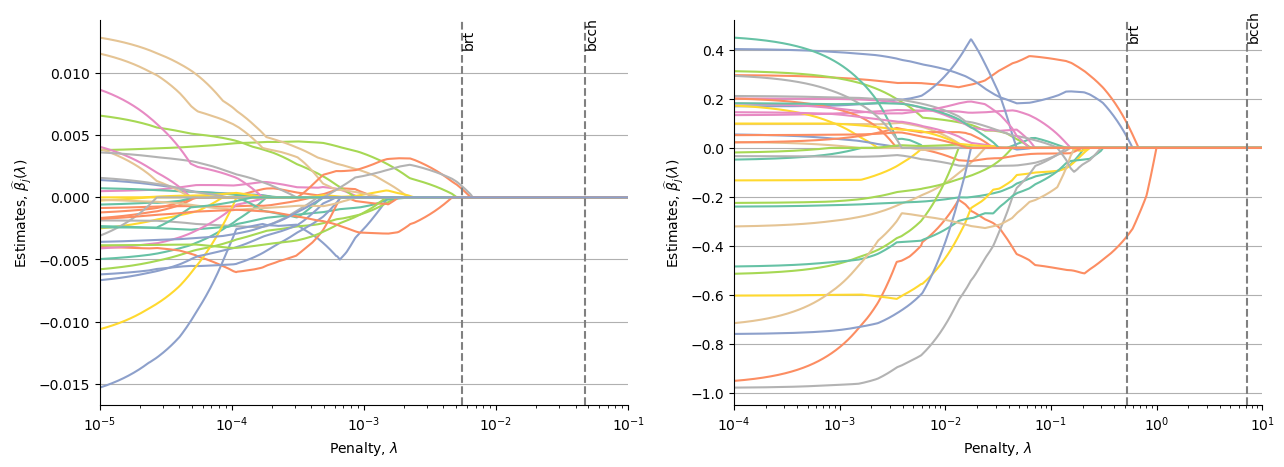

In [71]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

# Plot lasso path for step 1
lm.plot_lasso_path(penalty_grid_1, 
                   [list(val.values()) for val in coefs1],
                   legends=xLabels, 
                   ax=ax[0], 
                   vlines={'brt':penalty_BRTyx,'bcch':penalty_BCCHyx},
                   title=None)

# Plot lasso path for step 2
lm.plot_lasso_path(penalty_grid_2, 
                   [list(val.values()) for val in coefs2],
                   legends=xLabels, 
                   ax=ax[1], 
                   vlines={'brt':penalty_BRTdz,'bcch':penalty_BCCHdz},
                   title=None)

fig.savefig('output/lasso_paths.png')